In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.colors as col
import sys
sys.path.append('/pool/firebolt1/p484/projects/huang/rings')
from continuumanalysis3 import Continuum
from analyzeradprofile import *
from fitellipse import *

In [2]:
disk = {'filename': '/data/sandrews/ALMA_disks/DR/OLD/fiducial_images/DoAr25_continuum.fits',
                          'distance':138,
                          'incl' : 65.8, 
                          'PA' : 110.4, 
                          'offsetx' : 11.1*.003,
                          'offsety' : -162.8*.003,
                          'size': 2.7,
                          'gamma': 0.7,
                         }
maxrad = 150
radialbins = 0.5+1*np.arange(maxrad)

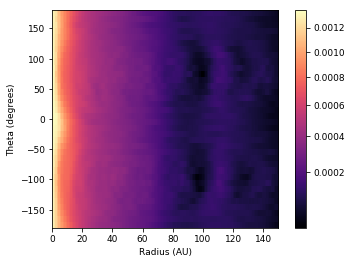

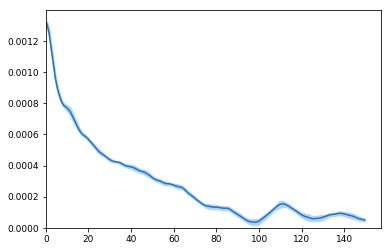

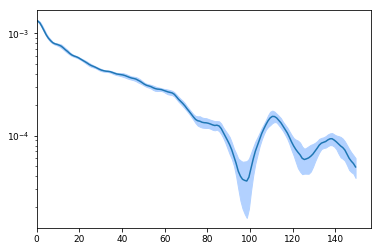

In [2]:


cont = Continuum(disk['filename'], disk['offsetx'],disk['offsety'], disk['PA'], disk['incl'], disk['distance'])

_,_, rtmap = cont.azunwrap(radialbins, tbins = -175 + 10.*np.arange(36))

surfbrightness, SB_scatter = cont.radialprofile(radialbins, high_incl = True)
plt.imshow(rtmap,extent =[0, np.max(radialbins)+1, -180,180], 
           aspect = 0.4, origin = 'lower', cmap = 'magma', norm = col.PowerNorm(gamma = disk['gamma']))
plt.ylim(ymin = -180, ymax = 180)
plt.xlim(xmin=0, xmax=maxrad)
plt.xlim(xmin=0, xmax=maxrad)
plt.colorbar()
plt.xlabel('Radius (AU)')
plt.ylabel('Theta (degrees)')
plt.show()

plt.plot(radialbins, surfbrightness)
plt.fill_between(radialbins,(surfbrightness - SB_scatter),(surfbrightness + SB_scatter),facecolor = '#B2D1FF',edgecolor = '#B2D1FF')
plt.xlim(xmin = 0)
plt.ylim(ymin =0)

plt.show()


plt.semilogy(radialbins, surfbrightness)
plt.fill_between(radialbins,(surfbrightness - SB_scatter),(surfbrightness + SB_scatter),facecolor = '#B2D1FF',edgecolor = '#B2D1FF')
plt.xlim(xmin = 0)
plt.show()



/home/janehuan/anaconda/envs/py36/lib/python3.6/site-packages/matplotlib/colors.py:1257: UserWarning: Power-law scaling on negative values is ill-defined, clamping to 0.
  warnings.warn("Power-law scaling on negative values is "
/pool/firebolt1/p484/projects/huang/rings/fitellipse.py:59: ComplexWarning: Casting complex values to real discards the imaginary part
  for dx in roots[np.where(np.isreal(roots))].astype(np.float64):


The MLE offsets are delta_x = 3.988e-02 arcsec, delta_y = -4.945e-01 arcsec
The MLE semi-major axis is r = 0.710 arcsec
The MLE inclination is i = 68.202 degrees
The MLE position angle is PA = 110.887 degrees
The MLE log-variance in the pixel offsets from the true ellipse is -9.378e+00


/home/janehuan/anaconda/envs/py36/lib/python3.6/site-packages/matplotlib/colors.py:1218: RuntimeWarning: invalid value encountered in power
  np.power(resdat, gamma, resdat)


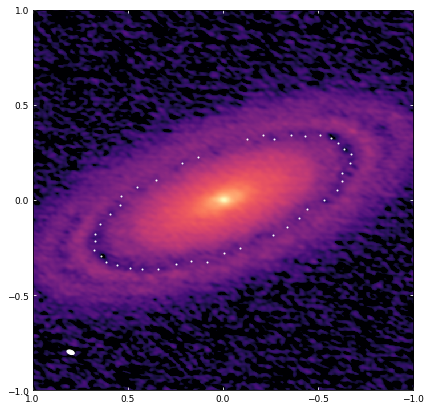

In [3]:

# Extract the gap that's at ~95 AU
xcoords1, ycoords1 = cont.extract_ring(85,105,tbins = -176+8*np.arange(45), extract_type = 'min')

cont.plot_extracted_ring(cont,xcoords1, ycoords1, 0.4, 2)

#get maximum likelihood estimates and check that ellipse parameters seem reasonable
mle_1 = ellipse_mle([disk["offsetx"],
                     disk["offsety"],
                     90/140.,
                     np.cos(disk["incl"]*np.pi/180.),
                     disk["PA"]*np.pi/180., 
                     np.log(.01**2)], 
                    xcoords1, ycoords1)

In [6]:
#do mcmc fit
def lnprior(ellipse_params):
    x0, y0, r0, cosi, par, logvar = ellipse_params
    if -4.5 < x0 < 4.5 and -4.5 < y0 < 4.5 and 0 < r0 < 4.5 and 0<cosi<1 and 0 < par < np.pi and -15<logvar<-5:
        return 0.0
    return -np.inf

def lnprob(ellipse_params, xcoord, ycoord):
    lp = lnprior(ellipse_params)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike(ellipse_params, xcoord, ycoord)

nwalkers = 30
nthreads = 8
nsteps = 20000
sampler1 = run_mcmc(nwalkers, nthreads, nsteps, mle_1, lnprob, xcoords1, ycoords1)

/pool/firebolt1/p484/projects/huang/rings/fitellipse.py:59: ComplexWarning: Casting complex values to real discards the imaginary part
  for dx in roots[np.where(np.isreal(roots))].astype(np.float64):
/pool/firebolt1/p484/projects/huang/rings/fitellipse.py:59: ComplexWarning: Casting complex values to real discards the imaginary part
  for dx in roots[np.where(np.isreal(roots))].astype(np.float64):
/pool/firebolt1/p484/projects/huang/rings/fitellipse.py:59: ComplexWarning: Casting complex values to real discards the imaginary part
  for dx in roots[np.where(np.isreal(roots))].astype(np.float64):
/pool/firebolt1/p484/projects/huang/rings/fitellipse.py:59: ComplexWarning: Casting complex values to real discards the imaginary part
  for dx in roots[np.where(np.isreal(roots))].astype(np.float64):
/pool/firebolt1/p484/projects/huang/rings/fitellipse.py:59: ComplexWarning: Casting complex values to real discards the imaginary part
  for dx in roots[np.where(np.isreal(roots))].astype(np.float

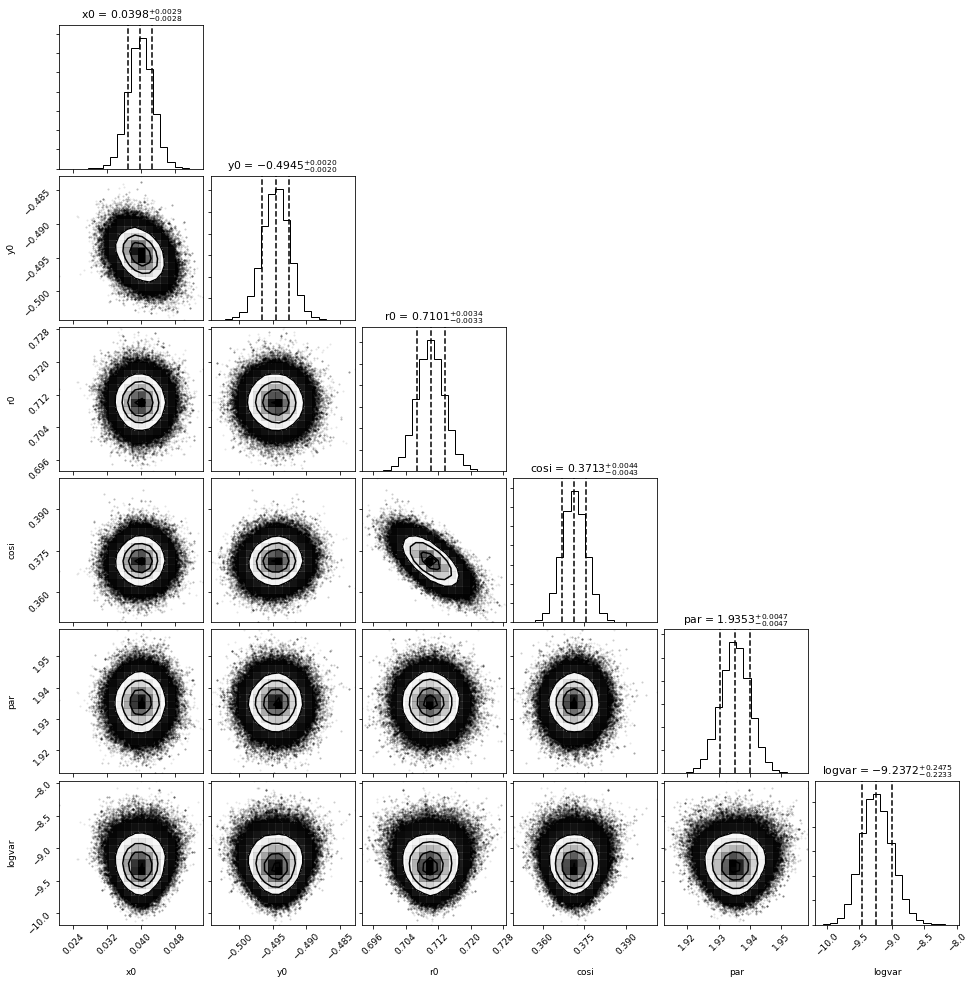

The x offset is delta_x = 3.98e-02 arcsec (+2.9e-03, -2.8e-03)
The y offset is delta_y = -4.95e-01 arcsec (+2.0e-03, -2.0e-03)
The median semi-major axis is r = 0.7101 arcsec (+0.0034, -0.0033) 
or 98.00 AU (+0.27, -0.28)
The incl is i = 68.21 deg (+0.27, -0.27)
The median position angle is PA = 110.88 deg (+0.27, -0.27)
The median log-variance in the pixel offsets from the true ellipse is -9.237e+00


In [7]:

plot_corner(sampler1, 500, 1)
sampler_results(sampler1, 500, cont.src_distance)

/home/janehuan/anaconda/envs/py36/lib/python3.6/site-packages/matplotlib/colors.py:1257: UserWarning: Power-law scaling on negative values is ill-defined, clamping to 0.
  warnings.warn("Power-law scaling on negative values is "
/pool/firebolt1/p484/projects/huang/rings/fitellipse.py:59: ComplexWarning: Casting complex values to real discards the imaginary part
  for dx in roots[np.where(np.isreal(roots))].astype(np.float64):


The MLE offsets are delta_x = 3.439e-02 arcsec, delta_y = -4.933e-01 arcsec
The MLE semi-major axis is r = 0.806 arcsec
The MLE inclination is i = 66.058 degrees
The MLE position angle is PA = 110.217 degrees
The MLE log-variance in the pixel offsets from the true ellipse is -8.747e+00


/home/janehuan/anaconda/envs/py36/lib/python3.6/site-packages/matplotlib/colors.py:1218: RuntimeWarning: invalid value encountered in power
  np.power(resdat, gamma, resdat)


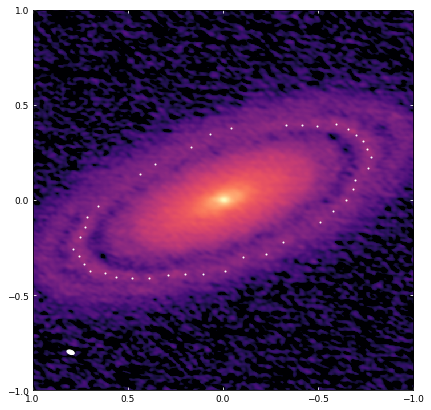

In [10]:

# Extract the ring that's at 110 AU
xcoords2, ycoords2 = cont.extract_ring(105,120,tbins = -176+8*np.arange(45), extract_type = 'max')

cont.plot_extracted_ring(cont,xcoords2, ycoords2, 0.4, 2)

#get maximum likelihood estimates and check that ellipse parameters seem reasonable
mle_2 = ellipse_mle([disk["offsetx"],
                     disk["offsety"],
                     100/140.,
                     np.cos(disk["incl"]*np.pi/180.),
                     disk["PA"]*np.pi/180., 
                     np.log(.01**2)], 
                    xcoords2, ycoords2)

In [11]:
sampler2 = run_mcmc(nwalkers, nthreads, nsteps, mle_2, lnprob, xcoords2, ycoords2)

/pool/firebolt1/p484/projects/huang/rings/fitellipse.py:59: ComplexWarning: Casting complex values to real discards the imaginary part
  for dx in roots[np.where(np.isreal(roots))].astype(np.float64):
/pool/firebolt1/p484/projects/huang/rings/fitellipse.py:59: ComplexWarning: Casting complex values to real discards the imaginary part
  for dx in roots[np.where(np.isreal(roots))].astype(np.float64):
/pool/firebolt1/p484/projects/huang/rings/fitellipse.py:59: ComplexWarning: Casting complex values to real discards the imaginary part
  for dx in roots[np.where(np.isreal(roots))].astype(np.float64):
/pool/firebolt1/p484/projects/huang/rings/fitellipse.py:59: ComplexWarning: Casting complex values to real discards the imaginary part
  for dx in roots[np.where(np.isreal(roots))].astype(np.float64):
/pool/firebolt1/p484/projects/huang/rings/fitellipse.py:59: ComplexWarning: Casting complex values to real discards the imaginary part
  for dx in roots[np.where(np.isreal(roots))].astype(np.float

In [81]:
np.savez("DoAr25ellipsechains.npz", DA98 = sampler1.chain, BR111 = sampler2.chain)

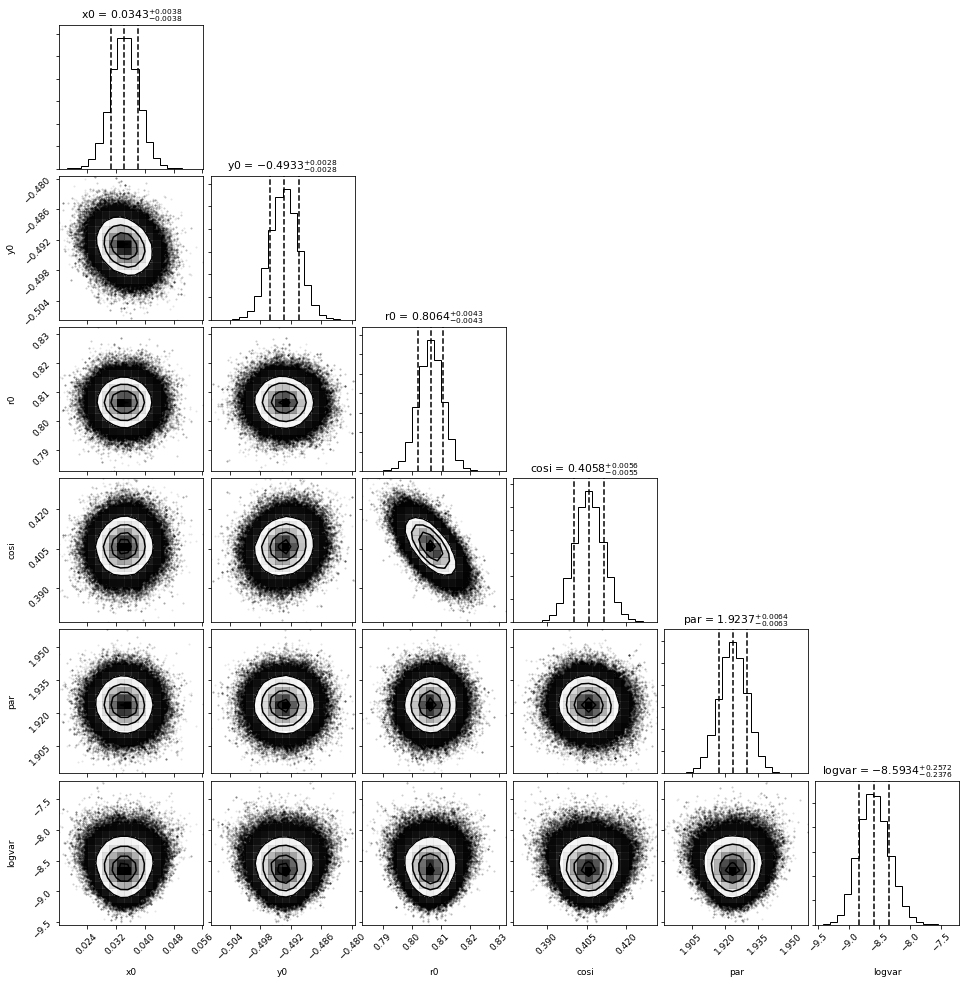

The x offset is delta_x = 3.43e-02 arcsec (+3.8e-03, -3.8e-03)
The y offset is delta_y = -4.93e-01 arcsec (+2.8e-03, -2.8e-03)
The median semi-major axis is r = 0.8064 arcsec (+0.0043, -0.0043) 
or 111.28 AU (+0.39, -0.39)
The incl is i = 66.06 deg (+0.34, -0.35)
The median position angle is PA = 110.22 deg (+0.36, -0.36)
The median log-variance in the pixel offsets from the true ellipse is -8.593e+00


In [12]:

plot_corner(sampler2, 500, 1)
sampler_results(sampler2, 500, cont.src_distance)

In [3]:
#make some preliminary plots
newcont = Continuum(disk['filename'], 0.0378,-0.494, 110.6, 67.4,disk['distance'])
    
_, _, newrtmap = newcont.azunwrap(radialbins, tbins = -175 + 10.*np.arange(36))

newsurfbrightness, newSB_scatter = newcont.radialprofile(radialbins, high_incl = True)

print("max",find_profile_extrema(radialbins, newsurfbrightness, extrema = 'max'))
print("min",find_profile_extrema(radialbins, newsurfbrightness, extrema = 'min'))

max [111, 137]
min [97, 125]


(array([  7,   8,   9,  10,  11,  12,  13,  14,  15,  16,  17,  18,  19,
        20,  21,  22,  23,  24,  25,  26,  27,  28,  29,  30,  31,  32,
        33,  34,  35,  36,  37,  38,  39,  40,  41,  42,  43,  44,  45,
        46,  47,  48,  49,  50,  51,  52,  53,  54,  55,  56,  57,  58,
        59,  60,  61,  62,  63,  64,  65,  66,  74,  75,  76,  77,  78,
        79,  80,  81,  82,  83,  84,  85,  86,  97,  98,  99, 100, 101,
       102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 125, 126,
       127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139,
       140, 141, 142, 143]),)


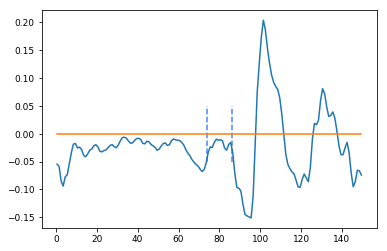

In [145]:
print(np.where(np.gradient(newsurfbrightness)/newsurfbrightness>-0.05))
plt.plot(radialbins, np.gradient(newsurfbrightness)/newsurfbrightness)
for feature in [74,86]:
    plt.vlines(feature,-0.05,0.05, color ='#4286f4', linestyles= 'dashed')
plt.plot(radialbins, np.zeros_like(radialbins))

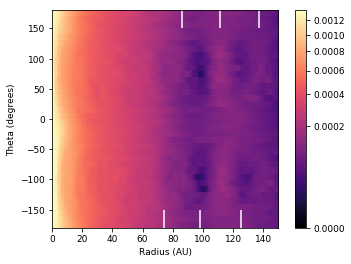

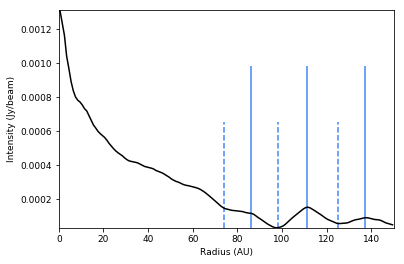

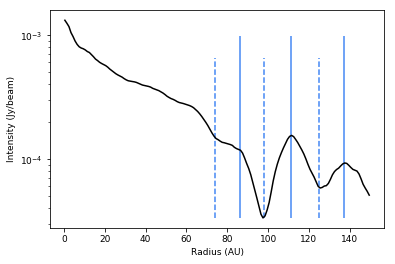

(0, 150)

/home/janehuan/anaconda/envs/py36/lib/python3.6/site-packages/matplotlib/colors.py:1218: RuntimeWarning: invalid value encountered in power
  np.power(resdat, gamma, resdat)


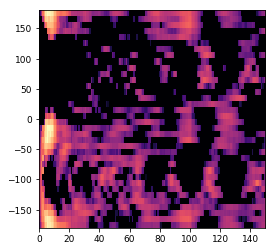

In [6]:
plt.imshow(newrtmap,extent =[0, np.max(radialbins)+1, -180,180], 
           aspect = 0.4, origin = 'lower', cmap = 'magma', vmin = 0, norm = col.PowerNorm(gamma = 0.4))
plt.ylim(ymin = -180, ymax = 180)
plt.xlim(xmin=0, xmax=maxrad)
plt.xlim(xmin=0, xmax=maxrad)
gaps = np.array([74,98,125])
rings = np.array([86,111.3,137])
for gap in gaps:
    plt.vlines(gap,-180,-150, color ='white')
for ring in rings:
    plt.vlines(ring,150,180, color ='white')
plt.colorbar()
plt.xlabel('Radius (AU)')
plt.ylabel('Theta (degrees)')
plt.show()


plt.plot(radialbins, newsurfbrightness, color = 'black')
for gap in gaps:
    plt.vlines(gap,np.min(newsurfbrightness),0.5*np.max(newsurfbrightness), color ='#4286f4', linestyles= 'dashed')
for ring in rings:
    plt.vlines(ring,np.min(newsurfbrightness),0.75*np.max(newsurfbrightness), color ='#4286f4')
plt.xlabel("Radius (AU)")
plt.ylabel("Intensity (Jy/beam)")
plt.xlim(xmin = 0, xmax = maxrad)
plt.ylim(ymin = np.min(newsurfbrightness), ymax = np.max(newsurfbrightness))
plt.show()

plt.semilogy(radialbins, newsurfbrightness, color = 'black')
for gap in gaps:
    plt.vlines(gap,np.min(newsurfbrightness),0.5*np.max(newsurfbrightness), color ='#4286f4', linestyles= 'dashed')
for ring in rings:
    plt.vlines(ring,np.min(newsurfbrightness),0.75*np.max(newsurfbrightness), color ='#4286f4')
plt.xlabel("Radius (AU)")
plt.ylabel("Intensity (Jy/beam)")
plt.show()

plt.imshow(newrtmap-np.percentile(newrtmap, 50, axis =0),extent =[0, np.max(radialbins)+1, -180,180], 
           aspect = 0.4, origin = 'lower', cmap = 'magma', vmin = 0, norm = col.PowerNorm(gamma = 0.3))
plt.ylim(ymin = -180, ymax = 180)
plt.xlim(xmin=0, xmax=maxrad)
plt.xlim(xmin=0, xmax=maxrad)


In [4]:
calc_contrast(98, 111.3, radialbins, newsurfbrightness, newSB_scatter, newcont, high_incl = True)

(0.2161150879804406, 0.041216436885868547)

In [5]:
calc_contrast(125.001, 137.001, radialbins, newsurfbrightness, newSB_scatter, newcont, high_incl = True)

(0.62814241042972963, 0.047993915426328561)

In [14]:
measure_widths(98,111.3, radialbins, newsurfbrightness, 0, 125)

9.40862674631e-05 104.8


(15.5, 14.299999999999997)

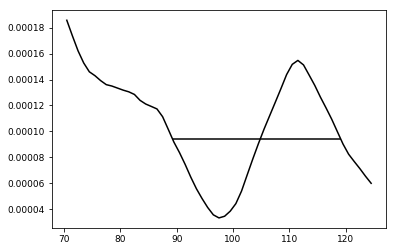

In [16]:
plt.plot(radialbins[70:125], newsurfbrightness[70:125], color = 'black')
plt.hlines(9.40862674631e-05, 104.8-15.5,104.8)
plt.hlines(9.40862674631e-05, 104.8,104.8+14.3)

In [18]:
measure_widths(125.001,137.001, radialbins, newsurfbrightness, 111, 150)

7.5506381955e-05 131.7


(9.9999999999999858, 12.800000000000011)

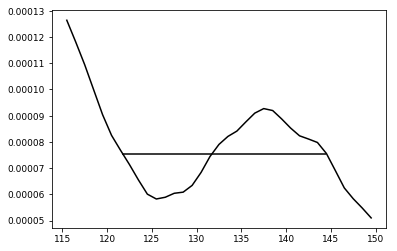

In [21]:
plt.plot(radialbins[115:150], newsurfbrightness[115:150], color = 'black')
plt.hlines(7.5506381955e-05, 131.7-10,131.7)
plt.hlines(7.5506381955e-05, 131.7,131.7+12.8)

In [26]:
bins = 0.5+1*np.arange(0, 300)

cumeflux = newcont.cumefluxprofile(bins)

164.5


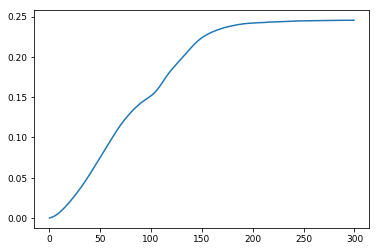

In [27]:
plt.plot(bins, cumeflux)
print(bins[np.argmin(np.abs(cumeflux-0.95*np.max(cumeflux)))])